In [113]:
%pip install calplot


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


# Garmin Activity Analysis

I purchased a Garmin Forerunner 245 as a gift for losing 100lbs.  That was in early January and i was curioys to see what I've done with this watch so far.

In [114]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import calplot
import plotly.express as px
from jupyter_dash import JupyterDash
from dash import Dash, dcc, html, Input, Output

pd.set_option('display.max_columns', 999)
%matplotlib inline
plt.style.use('ggplot')


In [115]:
df = pd.read_csv('data/garmin_activities.csv')
df_activities = df


## Data Cleaning

### Cleaning columns 'sport'

In [116]:
df_activities.loc[(df_activities['sport'] == 'fitness_equipment'),
                  'sport'] = df_activities['sub_sport']


In [117]:
df_activities['sport'] = pd.Categorical(df_activities['sport'])

# df_activities['elapsed_time'].dt.total_seconds

### Cleaning and adding time columns

In [118]:
df_activities['start_time'] = pd.to_datetime(df_activities['start_time'])


df_activities['start_date'] = df_activities['start_time'].apply(lambda x: x.date())
df_activities['hour'] = df_activities['start_time'].apply(lambda x: x.hour)


In [119]:
df_activities['start_date'] = pd.to_datetime(df_activities['start_date'])
df_activities['month'] = df_activities['start_date'].apply(lambda x: x.month)
df_activities['week'] = df_activities['start_date'].apply(lambda x: x.week)
df_activities['day_name'] = df_activities['start_date'].apply(lambda x: x.day_name())
df_activities['day_date'] = df_activities['start_date'].apply(lambda x: x.day)


In [120]:
df_activities['elapsed_time'] = pd.to_datetime(df_activities['elapsed_time'])

df_activities['start_minute'] = df_activities['elapsed_time'].apply(
    lambda x: x.minute)
df_activities['start_second'] = df_activities['elapsed_time'].apply(
    lambda x: x.second)
df_activities['start_microsecond'] = df_activities['elapsed_time'].apply(
    lambda x: x.microsecond)


In [121]:
# df_activities.loc[*]

In [122]:
df_activities.sort_values(by='start_time', ascending=True,
                          inplace=True, ignore_index=True)


In [123]:
df_activities['elapsed_time'] = pd.to_datetime(df_activities['elapsed_time'])


In [124]:
index = df_activities.loc[df_activities['elapsed_time'].dt.minute == 0].index
df_activities.drop(index, inplace=True)


In [125]:
# function to calculate calory/min, store h m s ms as variables
def calories_per_minute(df):
    min = df['start_minute']
    sec = df['start_second'] / 60
    ms = df['start_microsecond'] / 60000
    calories = df['calories']

    time = min + sec + ms
    return calories / time


df_activities['calpermin'] = df_activities.apply(lambda x: calories_per_minute(
    x[['start_minute', 'start_second', 'start_microsecond', 'calories']]), axis=1)


In [126]:
# function to calculate calory/min, store h m s ms as variables
def total_time(df):
    min = df['start_minute']
    sec = df['start_second'] / 60

    time = min + sec 
    return time


df_activities['total_time'] = df_activities.apply(lambda x: total_time(
    x[['start_minute', 'start_second', 'start_microsecond', ]]), axis=1)


In [127]:
def work_day(df):
    day = df['day_name']
    work_day 

    if day == 'Wednesday' or day == 'Thursday':
        return 'Off Day'
    else:
        return 'Work Day' 

df_activities['work_day'] = df_activities.apply(lambda x: work_day(x[['day_name']]), axis=1)

In [128]:
df_activities.head()


,activity_id,name,description,type,course_id,laps,sport,sub_sport,training_effect,anaerobic_training_effect,start_time,stop_time,elapsed_time,moving_time,distance,cycles,avg_hr,max_hr,avg_rr,max_rr,calories,avg_cadence,max_cadence,avg_speed,max_speed,ascent,descent,max_temperature,min_temperature,avg_temperature,start_lat,start_long,stop_lat,stop_long,hr_zones_method,hrz_1_hr,hrz_2_hr,hrz_3_hr,hrz_4_hr,hrz_5_hr,hrz_1_time,hrz_2_time,hrz_3_time,hrz_4_time,hrz_5_time,start_date,hour,month,week,day_name,day_date,start_minute,start_second,start_microsecond,calpermin,total_time,work_day
0,10275535173,Indoor Cycling,NaN,uncategorized,NaN,1,cycling,indoor_cycling,0.2,0.0,2023-01-09 11:14:38,2023-01-09 11:18:50.000000,2023-04-19 00:04:01.260,00:04:01.260000,0.000000,NaN,107.0,121.0,NaN,NaN,38,NaN,NaN,0.000000,NaN,NaN,NaN,260.6,NaN,260.6,NaN,NaN,NaN,NaN,max_heart_rate,99.0,119.0,139.0,158.0,178.0,00:03:12.999000,00:00:18.862000,00:00:00.000000,00:00:00.000000,00:00:00.000000,2023-01-09,11,1,2,Monday,9,4,1,260000,4.550898,4.016667,Work Day
1,10275535206,Indoor Cycling,NaN,uncategorized,NaN,1,cycling,indoor_cycling,0.4,0.0,2023-01-09 11:19:07,2023-01-09 11:24:07.000000,2023-04-19 00:04:46.379,00:04:46.379000,0.000000,NaN,121.0,127.0,NaN,NaN,60,NaN,NaN,0.000000,NaN,NaN,NaN,260.6,NaN,260.6,NaN,NaN,NaN,NaN,max_heart_rate,99.0,119.0,139.0,158.0,178.0,00:00:44.698000,00:04:01.681000,00:00:00.000000,00:00:00.000000,00:00:00.000000,2023-01-09,11,1,2,Monday,9,4,46,379000,5.413534,4.766667,Work Day
2,10275535247,Treadmill Running,NaN,uncategorized,NaN,2,running,treadmill,2.6,0.0,2023-01-09 11:27:01,2023-01-09 11:39:21.000000,2023-04-19 00:11:54.340,00:11:54.340000,0.999998,868.0,154.0,166.0,NaN,NaN,218,73.0,76.0,5.039817,6.534090,NaN,NaN,260.6,NaN,260.6,NaN,NaN,NaN,NaN,max_heart_rate,99.0,119.0,139.0,158.0,178.0,00:00:15.000000,00:00:21.001000,00:02:20.000000,00:08:09.335000,00:00:00.000000,2023-01-09,11,1,2,Monday,9,11,54,340000,12.409867,11.900000,Work Day
3,10275535278,Treadmill Running,NaN,uncategorized,NaN,2,running,treadmill,2.8,0.0,2023-01-09 11:39:38,2023-01-09 11:52:27.000000,2023-04-19 00:12:42.370,00:12:42.370000,1.081434,918.0,164.0,173.0,NaN,NaN,249,72.0,78.0,5.106925,6.135916,NaN,NaN,260.6,NaN,260.6,NaN,NaN,NaN,NaN,max_heart_rate,99.0,119.0,139.0,158.0,178.0,00:00:00.000000,00:00:27.063000,00:02:11.307000,00:10:03.997000,00:00:00.000000,2023-01-09,11,1,2,Monday,9,12,42,370000,13.197880,12.700000,Work Day
4,10278242382,Indoor Cycling,NaN,uncategorized,NaN,1,cycling,indoor_cycling,0.8,0.0,2023-01-09 20:59:26,2023-01-09 21:15:27.000000,2023-04-19 00:14:17.384,00:14:17.384000,0.000000,NaN,115.0,137.0,NaN,NaN,152,NaN,NaN,0.000000,NaN,NaN,NaN,260.6,NaN,260.6,NaN,NaN,NaN,NaN,max_heart_rate,99.0,119.0,139.0,158.0,178.0,00:06:29.195000,00:06:35.999000,00:00:00.000000,00:00:00.000000,00:00:00.000000,2023-01-09,20,1,2,Monday,9,14,17,384000,7.348912,14.283333,Work Day


In [129]:
df_activities.columns


Index(['activity_id', 'name', 'description', 'type', 'course_id', 'laps',
       'sport', 'sub_sport', 'training_effect', 'anaerobic_training_effect',
       'start_time', 'stop_time', 'elapsed_time', 'moving_time', 'distance',
       'cycles', 'avg_hr', 'max_hr', 'avg_rr', 'max_rr', 'calories',
       'avg_cadence', 'max_cadence', 'avg_speed', 'max_speed', 'ascent',
       'descent', 'max_temperature', 'min_temperature', 'avg_temperature',
       'start_lat', 'start_long', 'stop_lat', 'stop_long', 'hr_zones_method',
       'hrz_1_hr', 'hrz_2_hr', 'hrz_3_hr', 'hrz_4_hr', 'hrz_5_hr',
       'hrz_1_time', 'hrz_2_time', 'hrz_3_time', 'hrz_4_time', 'hrz_5_time',
       'start_date', 'hour', 'month', 'week', 'day_name', 'day_date',
       'start_minute', 'start_second', 'start_microsecond', 'calpermin',
       'total_time', 'work_day'],
      dtype='object')

In [130]:
df_activities = df_activities[[
    'name', 'sport', 'training_effect', 'anaerobic_training_effect',
    'start_time', 'stop_time', 'elapsed_time',
    'distance', 'avg_hr', 'max_hr', 'calories',
    'avg_cadence', 'max_cadence', 'avg_speed', 'max_speed', 'ascent',
    'descent', 'start_lat', 'start_long', 'stop_lat', 'stop_long',
    'start_date', 'hour', 'month', 'week', 'day_name', 'day_date', 'start_minute', 'start_second',
    'start_microsecond', 'calpermin', 'total_time', 'work_day'
]]


In [131]:
df_activities.describe()

,training_effect,anaerobic_training_effect,distance,avg_hr,max_hr,calories,avg_cadence,max_cadence,avg_speed,max_speed,ascent,descent,start_lat,start_long,stop_lat,stop_long,hour,month,week,day_date,start_minute,start_second,start_microsecond,calpermin,total_time
count,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,120.000000,123.000000,161.000000,85.000000,37.000000,38.000000,38.000000,38.000000,38.000000,38.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000
mean,1.986957,0.014286,0.979724,138.155280,154.807453,258.273292,58.783333,69.634146,2.414325,6.254815,252.979358,273.000415,39.108469,-84.642113,39.108295,-84.642088,12.354037,2.142857,7.503106,15.819876,19.726708,21.223602,455757.763975,8.908870,20.080435
std,1.060019,0.067876,1.146806,18.207333,19.203683,159.919432,20.327232,18.947844,2.366844,5.424909,101.089108,144.934498,0.001315,0.002175,0.001436,0.002169,3.074919,1.083150,4.310053,8.983936,11.441693,17.809750,275742.923218,3.431335,11.417622
min,0.000000,0.000000,0.000000,75.000000,105.000000,24.000000,8.000000,26.000000,0.000000,2.442734,65.616798,9.842520,39.104707,-84.643636,39.104367,-84.644019,0.000000,1.000000,2.000000,1.000000,2.000000,0.000000,0.000000,1.853282,2.516667
25%,0.900000,0.000000,0.000000,124.000000,138.000000,115.000000,39.500000,59.500000,0.000000,4.988367,193.569554,194.389764,39.108358,-84.643101,39.108170,-84.643088,11.000000,1.000000,4.000000,9.000000,10.000000,6.000000,265000.000000,6.478261,10.200000
50%,2.300000,0.000000,0.448444,141.000000,163.000000,240.000000,71.000000,78.000000,3.458303,5.364173,252.624672,269.028872,39.108462,-84.642991,39.108424,-84.643009,11.000000,2.000000,6.000000,16.000000,20.000000,16.000000,419000.000000,9.121622,20.083333
75%,2.900000,0.000000,2.052631,155.000000,170.000000,385.000000,73.250000,79.000000,4.751252,5.907748,288.713911,329.724410,39.108626,-84.642269,39.108531,-84.642217,12.000000,3.000000,11.000000,24.000000,30.000000,38.000000,671000.000000,11.370609,30.050000
max,4.000000,0.600000,4.433353,170.000000,180.000000,814.000000,77.000000,106.000000,6.491588,49.695769,518.372704,816.929135,39.112093,-84.635264,39.111659,-84.635187,22.000000,4.000000,16.000000,31.000000,58.000000,59.000000,980000.000000,16.250000,58.550000


In [132]:
df_activities.head()

,name,sport,training_effect,anaerobic_training_effect,start_time,stop_time,elapsed_time,distance,avg_hr,max_hr,calories,avg_cadence,max_cadence,avg_speed,max_speed,ascent,descent,start_lat,start_long,stop_lat,stop_long,start_date,hour,month,week,day_name,day_date,start_minute,start_second,start_microsecond,calpermin,total_time,work_day
0,Indoor Cycling,cycling,0.2,0.0,2023-01-09 11:14:38,2023-01-09 11:18:50.000000,2023-04-19 00:04:01.260,0.000000,107.0,121.0,38,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-01-09,11,1,2,Monday,9,4,1,260000,4.550898,4.016667,Work Day
1,Indoor Cycling,cycling,0.4,0.0,2023-01-09 11:19:07,2023-01-09 11:24:07.000000,2023-04-19 00:04:46.379,0.000000,121.0,127.0,60,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-01-09,11,1,2,Monday,9,4,46,379000,5.413534,4.766667,Work Day
2,Treadmill Running,running,2.6,0.0,2023-01-09 11:27:01,2023-01-09 11:39:21.000000,2023-04-19 00:11:54.340,0.999998,154.0,166.0,218,73.0,76.0,5.039817,6.534090,NaN,NaN,NaN,NaN,NaN,NaN,2023-01-09,11,1,2,Monday,9,11,54,340000,12.409867,11.900000,Work Day
3,Treadmill Running,running,2.8,0.0,2023-01-09 11:39:38,2023-01-09 11:52:27.000000,2023-04-19 00:12:42.370,1.081434,164.0,173.0,249,72.0,78.0,5.106925,6.135916,NaN,NaN,NaN,NaN,NaN,NaN,2023-01-09,11,1,2,Monday,9,12,42,370000,13.197880,12.700000,Work Day
4,Indoor Cycling,cycling,0.8,0.0,2023-01-09 20:59:26,2023-01-09 21:15:27.000000,2023-04-19 00:14:17.384,0.000000,115.0,137.0,152,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-01-09,20,1,2,Monday,9,14,17,384000,7.348912,14.283333,Work Day


## Data Visualization

Text(0.5, 1.0, 'Activities Amount')

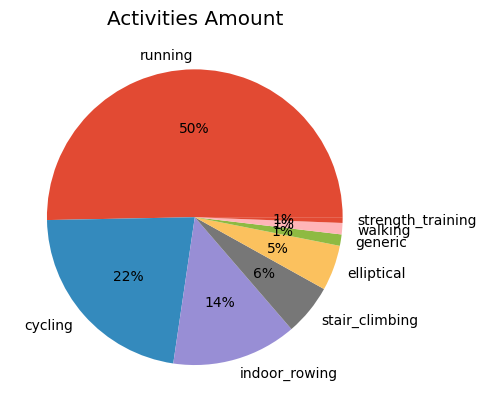

In [133]:
activities_pie = df_activities['sport'].value_counts().plot(
    kind='pie', autopct='%.0f%%',)
activities_pie.set_ylabel('')
activities_pie.set_title('Activities Amount')


<Axes: title={'center': 'Average Calories Burned per Activity'}, xlabel='sport'>

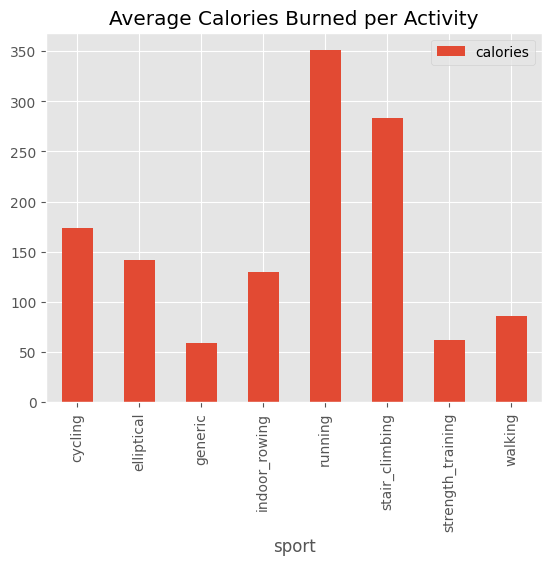

In [134]:
df_activities.groupby('sport').agg({
    'calories': 'mean'
}).plot(kind='bar', title='Average Calories Burned per Activity')


<Axes: xlabel='day_name', ylabel='calories'>

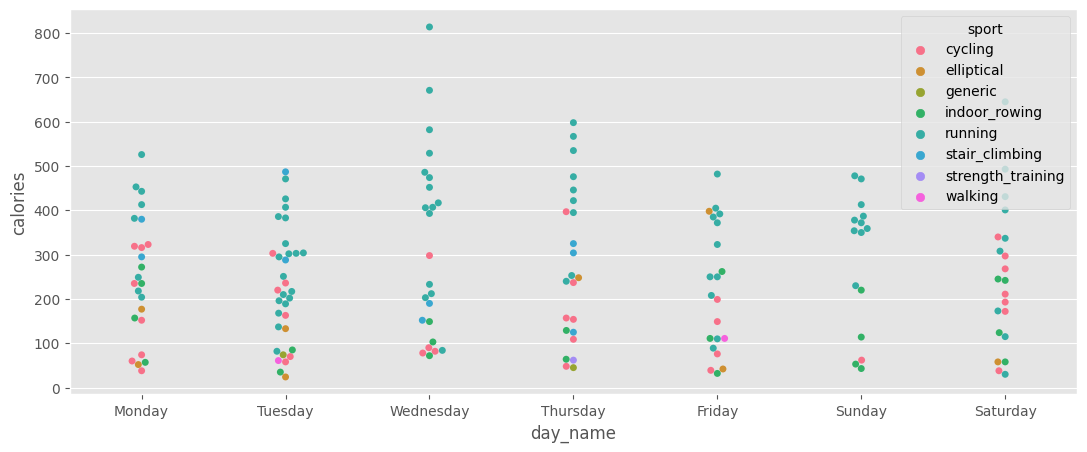

In [135]:
fig, ax = plt.subplots(1, 1, figsize=(13, 5))

sns.swarmplot(data=df_activities, x='day_name', y='calories', hue='sport', ax=ax,)


<Axes: xlabel='day_name', ylabel='hour'>

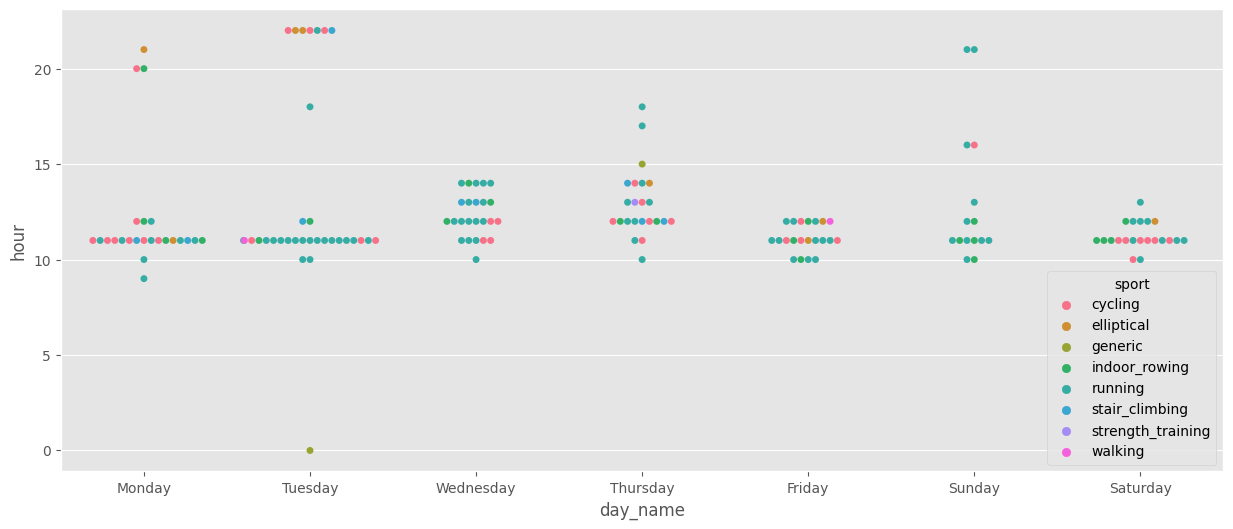

In [136]:
fig, ax = plt.subplots(figsize=(15, 6))

sns.swarmplot(x='day_name', y='hour', data=df_activities, hue='sport', size=5)

<Axes: xlabel='week', ylabel='calories'>

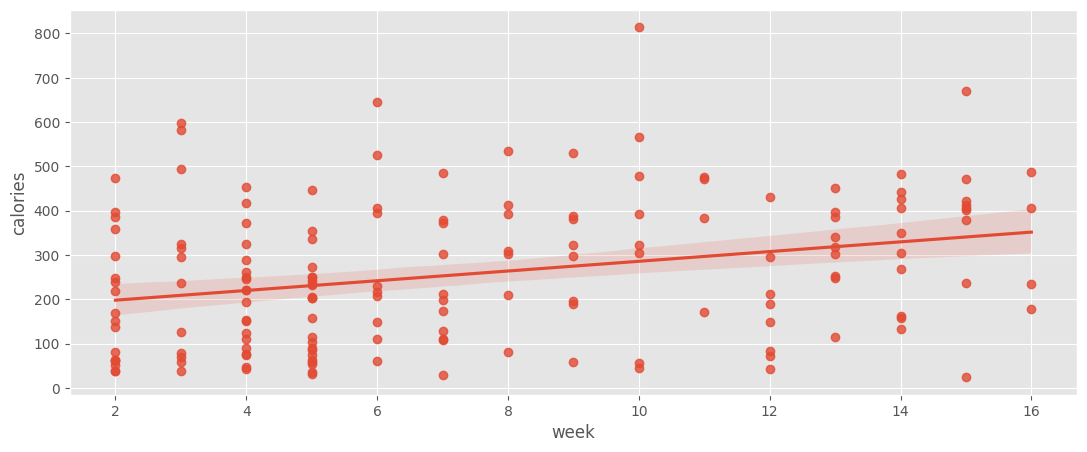

In [137]:
fig, ax = plt.subplots(1, 1, figsize=(13, 5))

sns.regplot(data=df_activities, x='week', y='calories',)


<Axes: xlabel='week', ylabel='avg_hr'>

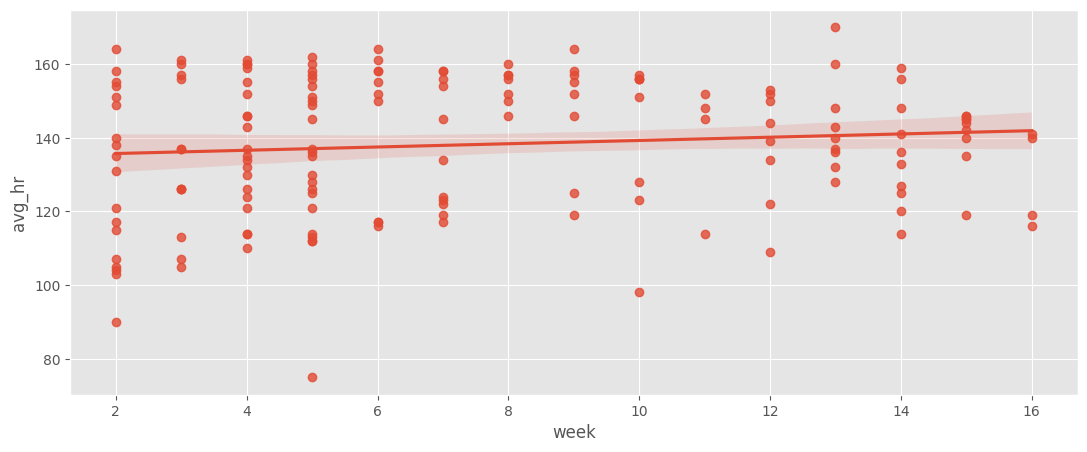

In [138]:
fig, ax = plt.subplots(1, 1, figsize=(13, 5))

sns.regplot(data=df_activities, x='week', y='avg_hr',)


<Axes: title={'center': 'Count of Start Hour'}, ylabel='Frequency'>

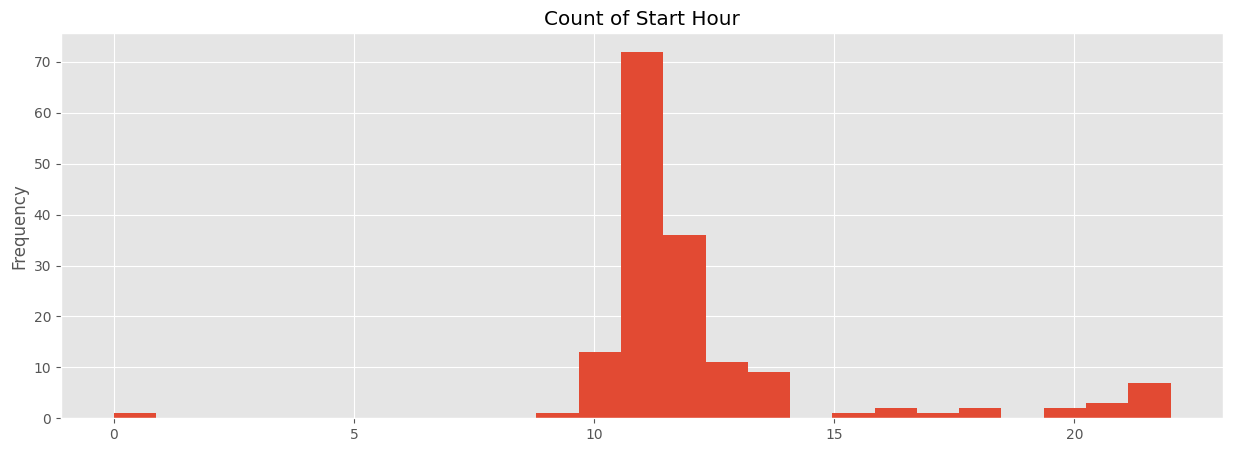

In [139]:
fig, ax1 = plt.subplots(figsize=(15, 5))

df_activities['hour'].plot(kind='hist', bins=25, title='Count of Start Hour')


findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.


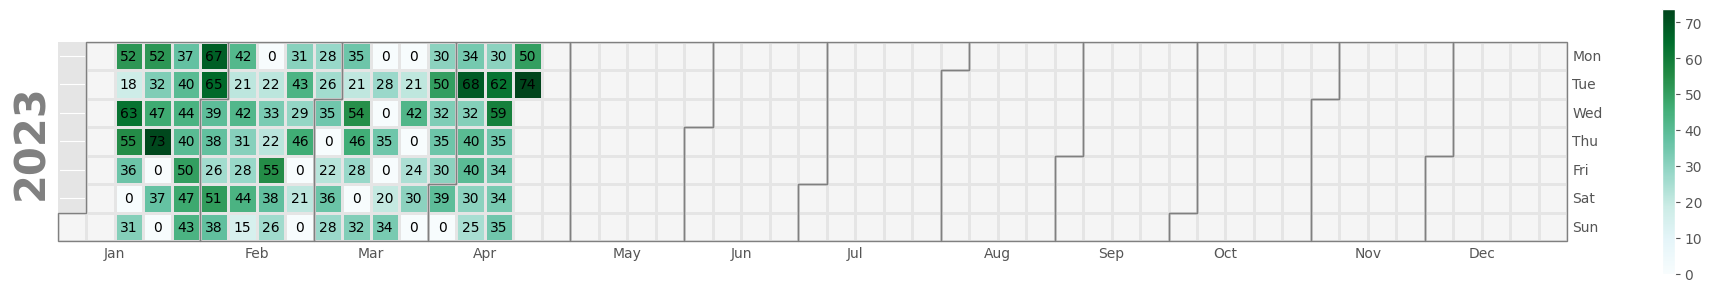

In [140]:
df__index = df_activities.set_index('start_date')
pl1 = calplot.calplot(data=df__index['total_time'], how='sum', figsize=(
    20, 3), suptitle='', textformat="{:1.0f}", cmap='BuGn', )


<Axes: xlabel='total_time', ylabel='Density'>

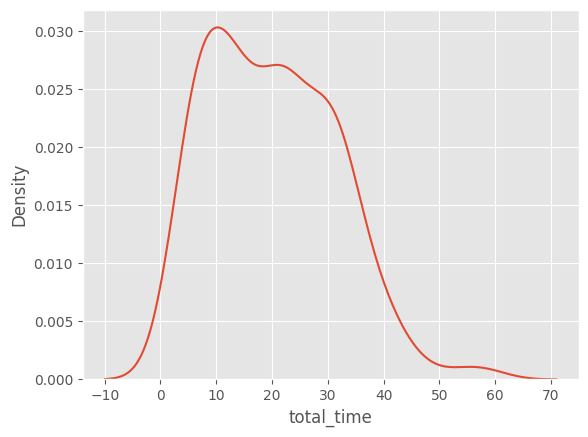

In [141]:
sns.kdeplot(data=df_activities, x='total_time')

<Axes: xlabel='month', ylabel='day_name'>

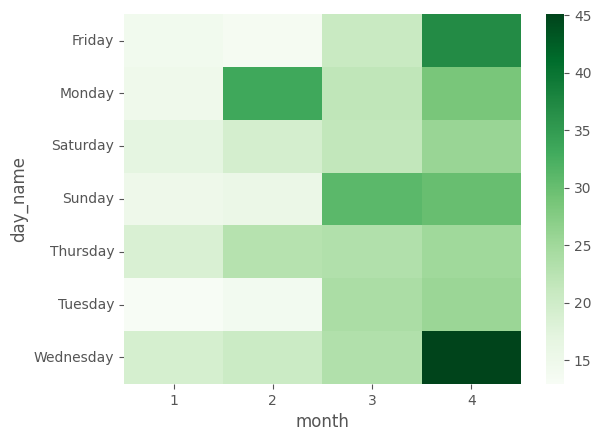

In [142]:
piv = pd.pivot_table(
    columns=df_activities['month'], values='total_time', index='day_name', aggfunc='mean', data=df_activities)
sns.heatmap(piv, cmap='Greens',)


In [143]:
df_activities

,name,sport,training_effect,anaerobic_training_effect,start_time,stop_time,elapsed_time,distance,avg_hr,max_hr,calories,avg_cadence,max_cadence,avg_speed,max_speed,ascent,descent,start_lat,start_long,stop_lat,stop_long,start_date,hour,month,week,day_name,day_date,start_minute,start_second,start_microsecond,calpermin,total_time,work_day
0,Indoor Cycling,cycling,0.2,0.0,2023-01-09 11:14:38,2023-01-09 11:18:50.000000,2023-04-19 00:04:01.260,0.000000,107.0,121.0,38,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-01-09,11,1,2,Monday,9,4,1,260000,4.550898,4.016667,Work Day
1,Indoor Cycling,cycling,0.4,0.0,2023-01-09 11:19:07,2023-01-09 11:24:07.000000,2023-04-19 00:04:46.379,0.000000,121.0,127.0,60,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-01-09,11,1,2,Monday,9,4,46,379000,5.413534,4.766667,Work Day
2,Treadmill Running,running,2.6,0.0,2023-01-09 11:27:01,2023-01-09 11:39:21.000000,2023-04-19 00:11:54.340,0.999998,154.0,166.0,218,73.0,76.0,5.039817,6.534090,NaN,NaN,NaN,NaN,NaN,NaN,2023-01-09,11,1,2,Monday,9,11,54,340000,12.409867,11.900000,Work Day
3,Treadmill Running,running,2.8,0.0,2023-01-09 11:39:38,2023-01-09 11:52:27.000000,2023-04-19 00:12:42.370,1.081434,164.0,173.0,249,72.0,78.0,5.106925,6.135916,NaN,NaN,NaN,NaN,NaN,NaN,2023-01-09,11,1,2,Monday,9,12,42,370000,13.197880,12.700000,Work Day
4,Indoor Cycling,cycling,0.8,0.0,2023-01-09 20:59:26,2023-01-09 21:15:27.000000,2023-04-19 00:14:17.384,0.000000,115.0,137.0,152,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-01-09,20,1,2,Monday,9,14,17,384000,7.348912,14.283333,Work Day
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,Delhi - Steady State Run,running,2.9,0.0,2023-04-16 10:09:26,2023-04-16 10:45:02.000000,2023-04-19 00:35:00.000,2.595834,140.0,175.0,413,68.0,79.0,4.449266,5.259037,219.816273,236.220473,39.108606,-84.643049,39.107866,-84.641332,2023-04-16,10,4,15,Sunday,16,35,0,0,11.800000,35.000000,Work Day
158,Elliptical,elliptical,0.9,0.0,2023-04-17 11:18:44,2023-04-17 11:39:01.000000,2023-04-19 00:20:08.310,0.000000,119.0,134.0,177,45.0,52.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-04-17,11,4,16,Monday,17,20,8,310000,6.996047,20.133333,Work Day
159,Indoor Cycling,cycling,0.9,0.0,2023-04-17 11:41:21,2023-04-17 12:12:44.000000,2023-04-19 00:30:07.365,0.000000,116.0,126.0,235,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-04-17,11,4,16,Monday,17,30,7,365000,6.491713,30.116667,Work Day
160,Delhi - Easy Run,running,2.7,0.0,2023-04-18 10:14:01,2023-04-18 10:48:01.000000,2023-04-19 00:33:38.410,2.514049,141.0,167.0,407,71.0,79.0,4.485057,5.071134,475.721786,242.782153,39.108351,-84.642456,39.108436,-84.643089,2023-04-18,10,4,16,Tuesday,18,33,38,410000,10.057661,33.633333,Work Day


<Axes: title={'center': 'Calories Burned Per Minute'}, xlabel='Calories', ylabel='Activity'>

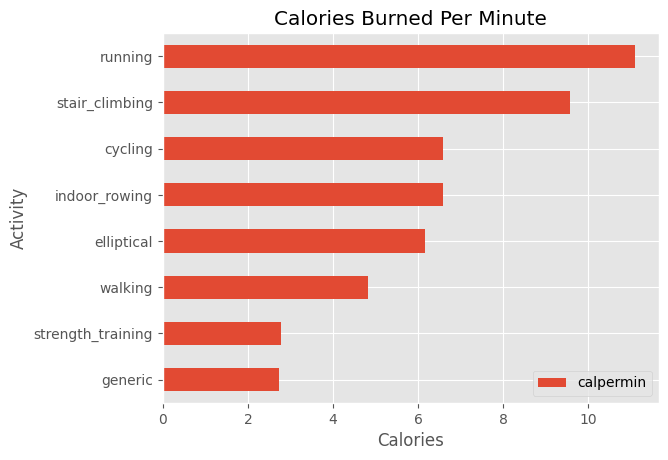

In [144]:
df_activities.groupby('sport').agg({
    'calpermin': 'mean'
}).sort_values('calpermin', ascending=True).plot(kind='barh', title='Calories Burned Per Minute', xlabel='Calories', ylabel='Activity')


<Axes: xlabel='week', ylabel='total_time'>

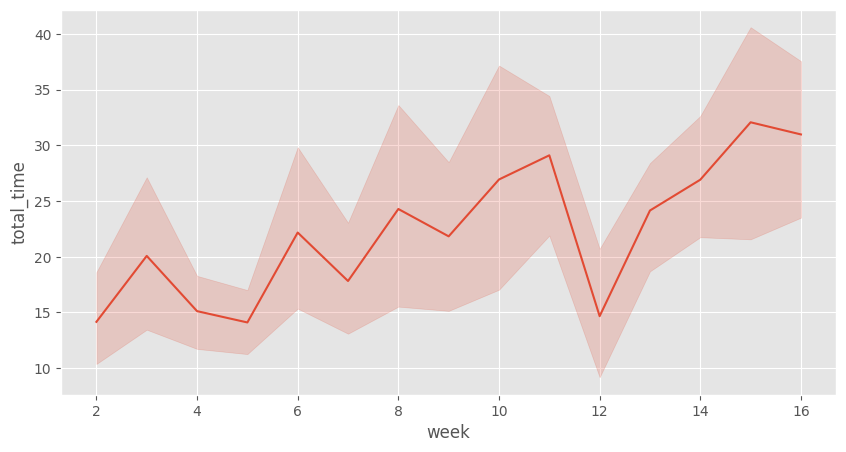

In [145]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

sns.lineplot(data=df_activities, x='week', y='total_time')


In [146]:
df_activities['sport'].value_counts().reset_index()

,index,sport
0,running,81
1,cycling,36
2,indoor_rowing,22
3,stair_climbing,9
4,elliptical,8
5,generic,2
6,walking,2
7,strength_training,1


In [147]:
app = JupyterDash(__name__)
df_activities['total_time'].replace(0, np.NaN, inplace=True)
fig = px.line(data_frame=df_activities, x='week', y='total_time')
act_pie = px.pie(df_activities['sport'].value_counts().reset_index(), values='sport', names='index')

app.layout = html.Div([
    html.H1('Hello, asd!'),
    dcc.Graph(figure=act_pie)
])

/tmp/ipykernel_4274/63306581.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [148]:
if __name__ == '__main__':
    app.run_server()

Dash is running on http://127.0.0.1:8050/

Dash app running on http://127.0.0.1:8050/


<Axes: >

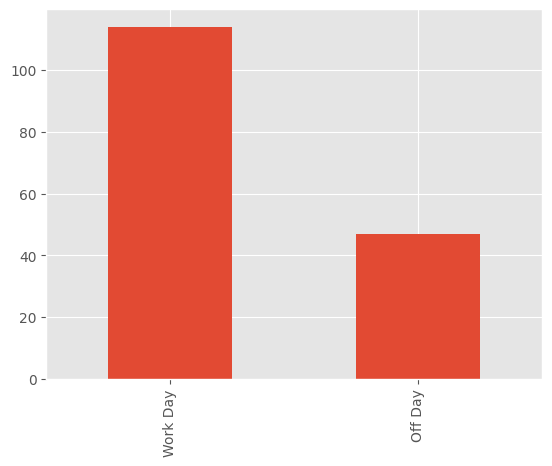

In [149]:
df_activities['work_day'].value_counts().plot(kind='bar')